Selected node:  (47, 9)
New strategy:  C


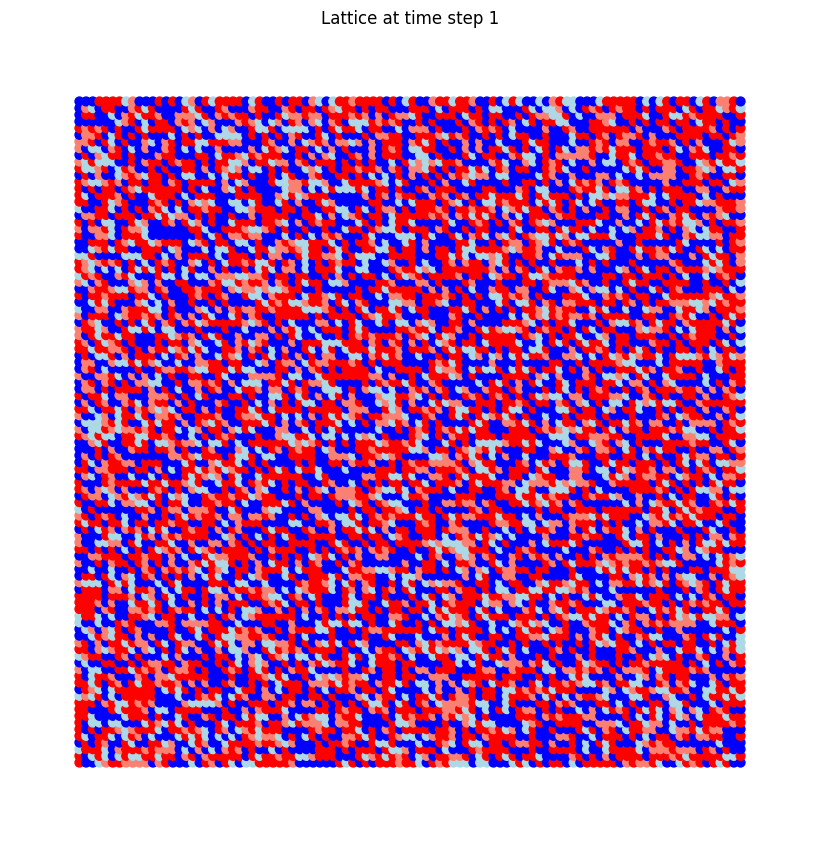

Selected node:  (81, 54)
New strategy:  C


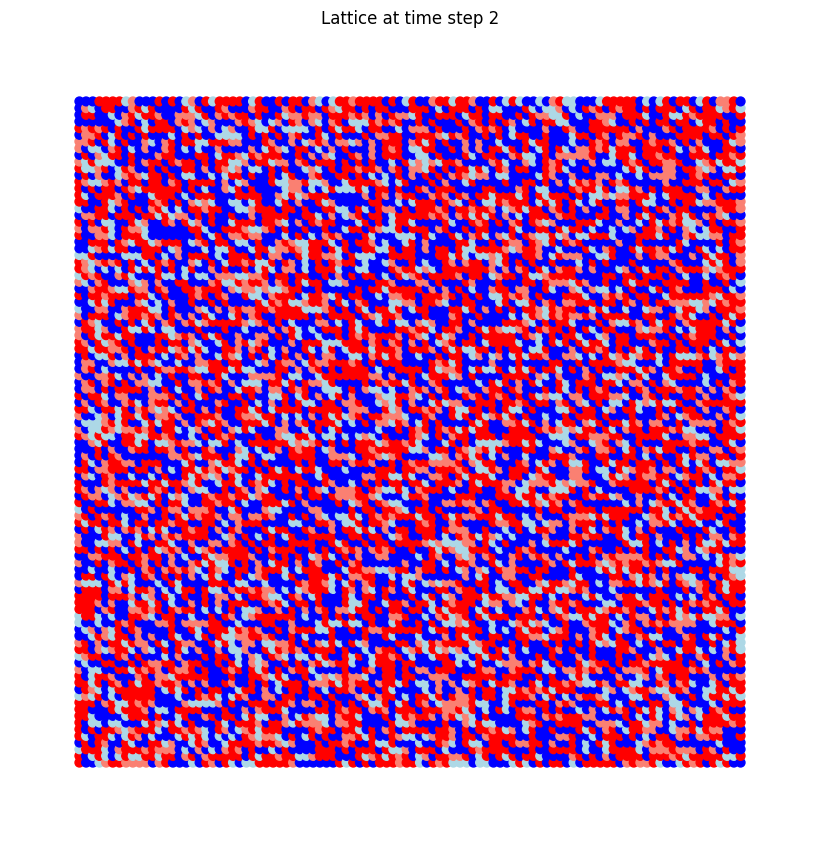

Selected node:  (90, 91)
New strategy:  C
Selected node:  (84, 15)
New strategy:  D
Selected node:  (62, 7)
New strategy:  C
Selected node:  (20, 42)
New strategy:  C
Selected node:  (17, 50)
New strategy:  D
Selected node:  (11, 98)
New strategy:  C
Selected node:  (4, 61)
New strategy:  C
Selected node:  (92, 27)
New strategy:  D
Selected node:  (30, 72)
New strategy:  D
Selected node:  (59, 65)
New strategy:  D
Selected node:  (91, 59)
New strategy:  D
Selected node:  (21, 71)
New strategy:  D
Selected node:  (32, 30)
New strategy:  D
Selected node:  (97, 36)
New strategy:  C
Selected node:  (98, 49)
New strategy:  C
Selected node:  (15, 81)
New strategy:  D
Selected node:  (26, 61)
New strategy:  D
Selected node:  (66, 77)
New strategy:  D
Selected node:  (43, 17)
New strategy:  D
Selected node:  (78, 12)
New strategy:  D
Selected node:  (41, 54)
New strategy:  D
Selected node:  (27, 93)
New strategy:  C
Selected node:  (76, 75)
New strategy:  C
Selected node:  (52, 20)
New strateg

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import logging

logging.basicConfig(filename='simulation_log.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# Adjust grid size to 30x30
GRID_SIZE = 100
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents
RICH_SITE_PROB = 0.3  # Fraction of rich sites (adjust as needed)
AVERAGE_SITE_PROB = 0.0  # Fraction of average sites (you can adjust as needed)
INITIAL_COOPERATION_PROB = 0.5
c = 10  # Resource contrast (c) between rich and poor sites
DEFECTOR_COST = 1  # A small cost or penalty for choosing defection
COOPERATION_CLUSTER_BONUS = 0.7
PUBLIC_GOOD_BONUS = 2  # r, public good bonus
b = 1.1  # Temptation to defect
TEMPTATION_LEVEL = b - 1
m = 10  # Parameter for strategy change

# Payoff matrix parameters
RICH_RESOURCE = 1 + c
AVERAGE_RESOURCE = (1 + c) / 2  # Average site resource
POOR_RESOURCE = 1

# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    assign_resources(G)
    initialize_strategies(G, INITIAL_COOPERATION_PROB)
    return G

# Assign resources to rich, poor, and average sites
def assign_resources(G):
    for node in G.nodes():
        rand = random.random()
        if rand < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        elif rand < RICH_SITE_PROB + AVERAGE_SITE_PROB:
            G.nodes[node]['resource'] = AVERAGE_RESOURCE
            G.nodes[node]['site_type'] = 'average'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

def log_payoff_grid(G, payoffs):
    grid_str = ""
    for i in range(GRID_SIZE):
        row_str = []
        for j in range(GRID_SIZE):
            node = (i, j)
            strategy = G.nodes[node]['strategy']
            payoff = payoffs.get(node, 0.0)  # Use .get() to avoid KeyError, default to 0.0 if not found
            row_str.append(f"{strategy}({payoff:.2f})")
        grid_str += "\t".join(row_str) + "\n"
    logging.info(f"Payoff Grid:\n{grid_str}")

# Initialize strategies for agents (either cooperate 'C' or defect 'D')
def initialize_strategies(G, cooperation_prob):
    for node in G.nodes():
        G.nodes[node]['strategy'] = 'C' if random.random() < cooperation_prob else 'D'

# Play the game for a selected node and its neighbors
def play_game(G, selected_node):
    payoffs = {}
    nodes_to_update = [selected_node] + list(G.neighbors(selected_node))
    for node in nodes_to_update:
        strategy = G.nodes[node]['strategy']
        site = G.nodes[node]['site_type']
        payoff = 0
        neighbors = list(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']
            neighbor_site = G.nodes[neighbor]['site_type']

            # Payoff matrix from the paper (rich, average, and poor site interactions)
            payoff += calculate_payoff(strategy, site, neighbor_strategy, neighbor_site)

        payoffs[node] = payoff
    #logging.info(f"Payoffs: {payoffs}")
    log_payoff_grid(G, payoffs)
    return payoffs

def calculate_payoff(strategy, site, neighbor_strategy, neighbor_site):
    payoff = 0
    b_local = b
    c_local = c

    # Simplified payoff calculation based on the site type and strategies
    if site == 'rich':
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 2 * c_local + 1
            else:
                payoff = c_local
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local * c_local + b_local + c_local
            else:
                payoff = b_local * c_local + b_local - 1
    else:  # site == 'poor'
        if strategy == 'C':
            if neighbor_strategy == 'C':
                payoff = 1
            else:
                payoff = 0
        else:  # strategy == 'D'
            if neighbor_strategy == 'C':
                payoff = b_local
            else:
                payoff = b_local - 1

    return payoff

# Update strategy for only the selected node
def update_strategy(G, payoffs, selected_node):
    mutation_prob = 0.00#0.05  # Small chance of strategy mutation
    m = 10  # Exponent

    node = selected_node
    if random.random() < mutation_prob:
        # Mutate strategy
        current_strategy = G.nodes[node]['strategy']
        new_strategy = 'C' if current_strategy == 'D' else 'D'
    else:
        neighbors = list(G.neighbors(node))
        neighbors.append(node)  # Include self in possible models
        total_payoff = 0.0
        payoff_list = []

        # Compute total payoff raised to exponent m
        for neighbor in neighbors:
            payoff = payoffs[neighbor]
            payoff_m = max(payoff, 0) ** m  # Ensure non-negative before raising to m
            payoff_list.append((neighbor, payoff_m))
            total_payoff += payoff_m

        if total_payoff == 0:
            # All payoffs are zero or negative; choose randomly
            selected_neighbor = random.choice(neighbors)
        else:
            # Select a neighbor proportional to payoff^m
            probabilities = [payoff_m / total_payoff for _, payoff_m in payoff_list]
            selected_neighbor = random.choices(
                [neighbor for neighbor, _ in payoff_list],
                weights=probabilities,
                k=1
            )[0]

        new_strategy = G.nodes[selected_neighbor]['strategy']
        print("Selected node: ", node)
        print("New strategy: ", new_strategy)
        logging.info(f"Selected node: {node}, New strategy: {new_strategy}")

    # Apply the new strategy to the node
    G.nodes[node]['strategy'] = new_strategy

#Visualization of the lattice with different colors for cooperators and defectors
def plot_lattice(G, timestep):
    """
    Plot a lattice where node color is determined by strategy and site_type.
    Cooperators (C) are blue or light blue based on site type.
    Defectors (D) are red or light red based on site type.
    """
    node_colors = []
    
    for node in G.nodes():
        strategy = G.nodes[node].get('strategy')  # 'C' or 'D'
        site_type = G.nodes[node].get('site_type')  # 'rich' or 'poor'
        #print("Site type: ", site_type)

        
        if strategy == 'C':
            if site_type == 'rich':
                node_colors.append('lightblue')  # Cooperators on rich sites
            else:
                node_colors.append('blue')       # Cooperators on poor sites
        elif strategy == 'D':
            if site_type == 'rich':
                node_colors.append('salmon') # Defectors on rich sites
            else:
                node_colors.append('red')        # Defectors on poor sites
        else:
            node_colors.append('grey')           # Default in case of missing strategy
    
    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(8, 8))
    
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='black', width=0.05)
  
    
    plt.title(f"Lattice at time step {timestep}")
    plt.show()

# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []
    num_time_steps = 50000  # Adjust as needed
    logging.info(f"========================================")
    logging.info(f"Simulation started")
    logging.info(f"=========================================")
    logging.info(f"Parameters: \nb: {b} \nC: {c}\nGrid size: {GRID_SIZE}\nRich site probability: {RICH_SITE_PROB}\nAverage site probability: {AVERAGE_SITE_PROB}\nInitial cooperation probability: {INITIAL_COOPERATION_PROB}")
    logging.info(f"=========================================")


    for t in range(num_time_steps):  # Simulate for specified time steps
        selected_node = random.choice(list(G.nodes()))
        logging.info(f"Step {t+1}")
        # Node plays the game with neighbors
        payoffs = play_game(G, selected_node)
        
        # Update strategy for only the selected node
        update_strategy(G, payoffs, selected_node)
        
        # Record cooperation level
        if t % 1000 == 0:  # Adjust frequency of recording as needed
            num_cooperators = sum(1 for node in G.nodes() if G.nodes[node]['strategy'] == 'C')
            cooperation_level = num_cooperators / NUM_AGENTS
            cooperation_levels.append(cooperation_level)
        
        # Visualization (optional)
        if t == 1:
            plot_lattice(G, t+1)
        if (t % 50000 == 0):
            plot_lattice(G, t+1)
    
    return cooperation_levels, G

# Run the simulation and plot the final state
cooperation_levels, G = simulate()

# Plot the cooperation level over time
plt.plot(cooperation_levels)
plt.xlabel("Time step (x1000)")
plt.ylabel("Cooperation level")
plt.title("Cooperation Level Over Time")
plt.show()
